In [11]:
import pandas as pd 
import plotnine as p9   
import numpy as np
import glob

In [12]:
path = "Simulations/results/car"
all_file = glob.glob(path + "/*.csv")
print(len(all_file))

dfs = [pd.read_csv(f) for f in all_file]
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df.keys(), "\n", combined_df.shape, "\n", combined_df.dtypes)

31


Index(['idx', 'model', 'estimand', 'gamma_noise', 'mean', 'median', 'true',
       'bias', 'std', 'RMSE', 'RMSE_rel', 'MAE', 'MAPE', 'q025', 'q975',
       'covering', 'mean_ind_cover', 'w_dist'],
      dtype='object') 
 (7611, 18) 
 idx               object
model             object
estimand          object
gamma_noise       object
mean              object
median            object
true              object
bias              object
std               object
RMSE              object
RMSE_rel          object
MAE               object
MAPE              object
q025              object
q975              object
covering          object
mean_ind_cover    object
w_dist            object
dtype: object


In [13]:
# to numeric
numeric_columns = combined_df.keys()[3:]

for col in numeric_columns:
    combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

print(combined_df.dtypes)

# combined_df["gamma_noise"] = pd.to_numeric(combined_df["gamma_noise"], errors='coerce')
# combined_df["mean"] = pd.to_numeric(combined_df["mean"], errors='coerce')
# combined_df["std"] = pd.to_numeric(combined_df["std"], errors='coerce')

idx                object
model              object
estimand           object
gamma_noise       float64
mean              float64
median            float64
true              float64
bias              float64
std               float64
RMSE              float64
RMSE_rel          float64
MAE               float64
MAPE              float64
q025              float64
q975              float64
covering          float64
mean_ind_cover    float64
w_dist            float64
dtype: object


c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_bin : Removed 14 rows containing non-finite values.
c:\Users\bar21\.conda\envs\STAT\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.


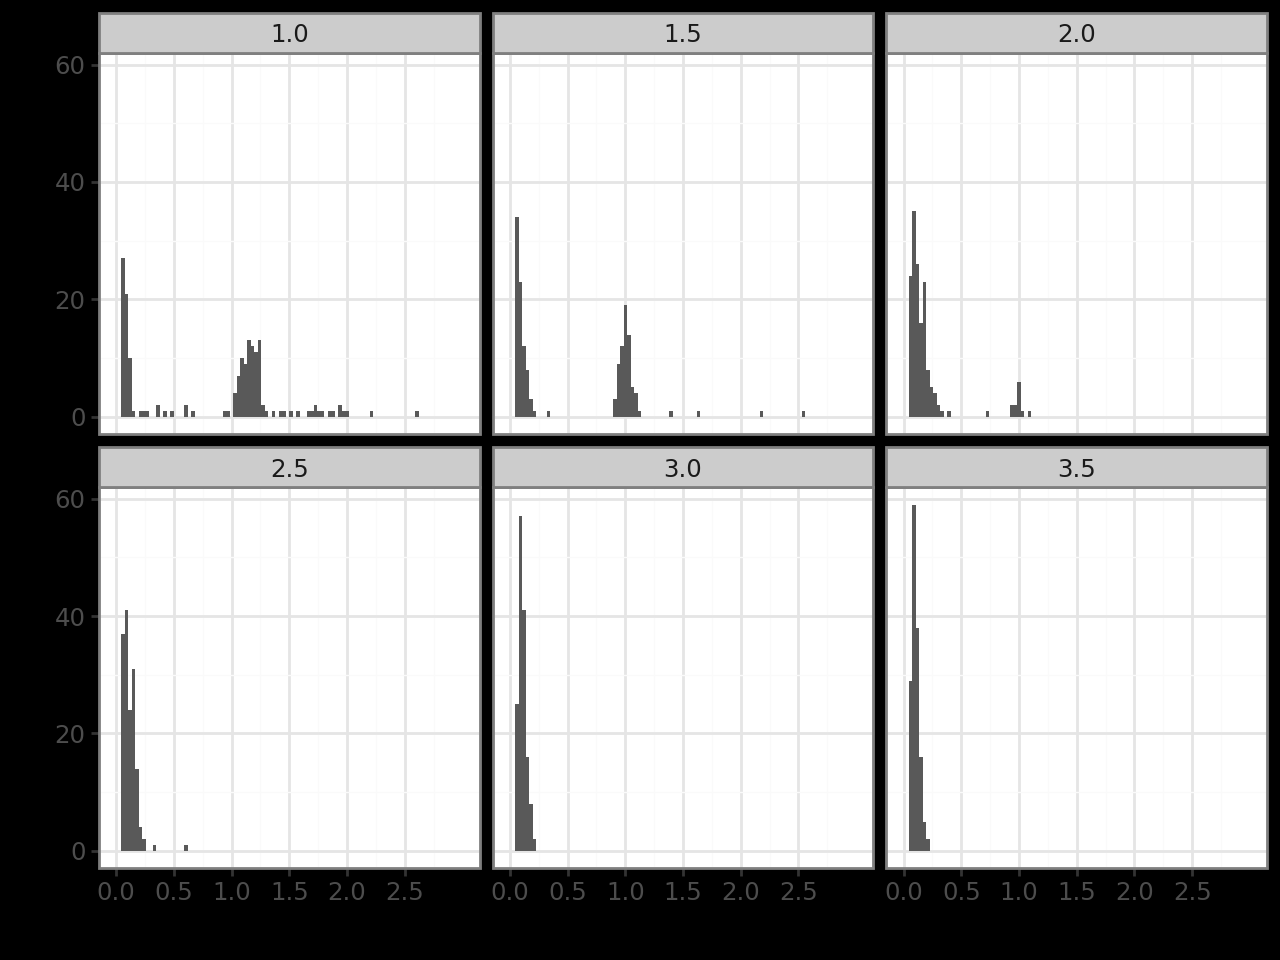

In [14]:

mwg_mask = combined_df['model'] == 'MWG'
# mwg_mask = combined_df['model'] == 'MWG_rep'
# mwg_mask = combined_df['model'] == 'obs_net'
# mwg_mask = combined_df['model'] == 'true_net'
stoch_mask = combined_df['estimand'] == 'stoch'
# stoch_mask = combined_df['estimand'] == 'dynamic'
# print(mwg_mask*stoch_mask)

(
p9.ggplot(combined_df[mwg_mask & stoch_mask],
        #   p9.aes(x="RMSE_rel"))
          p9.aes(x="MAPE"))
+ p9.geom_histogram(bins=100) 
+ p9.facet_wrap("gamma_noise", scales = "fixed")
+ p9.theme_bw()
+ p9.scale_x_continuous(breaks=np.arange(0, 3, .5),
                        limits=(0, 3))
)         

In [15]:
# print 5%, 25%, 50%, 75%, 95% quantiles of combined_df["RMSE_rel"] among mask idx by gamma_noise group

mask_idx = mwg_mask & stoch_mask

quantiles = combined_df[mask_idx].groupby("gamma_noise")["RMSE_rel"].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

print(quantiles)

gamma_noise      
1.0          0.05    0.075801
             0.25    0.109745
             0.50    1.075685
             0.75    1.181207
             0.95    1.719202
1.5          0.05    0.077281
             0.25    0.097730
             0.50    0.366050
             0.75    1.011340
             0.95    3.122235
2.0          0.05    0.079046
             0.25    0.106855
             0.50    0.146650
             0.75    0.202850
             0.95    0.998619
2.5          0.05    0.076357
             0.25    0.093392
             0.50    0.127010
             0.75    0.166857
             0.95    0.207142
3.0          0.05    0.079436
             0.25    0.097730
             0.50    0.121250
             0.75    0.145670
             0.95    0.186724
3.5          0.05    0.079404
             0.25    0.091770
             0.50    0.112910
             0.75    0.140370
             0.95    0.183400
Name: RMSE_rel, dtype: float64


In [16]:
# remove outlier with 'RMSE_rel' > 0.5 only for 'model' in ['MWG', 'MWG_rep'] 

# outlier_mask = combined_df['RMSE_rel'] < 0.5
# combined_df = combined_df[outlier_mask]

# # outlier_mask = combined_df['RMSE_rel'] < 1.0
# # combined_df = combined_df[outlier_mask]

# print(combined_df.shape)

mask = (~combined_df["model"].isin(["MWG", "MWG_rep"])) | (
    combined_df["model"].isin(["MWG", "MWG_rep"]) & (combined_df["RMSE_rel"] < 0.2)
    # combined_df["model"].isin(["MWG", "MWG_rep"]) & (combined_df["RMSE_rel"] < 0.3)
)

# Apply filtering
filtered_df = combined_df[mask].copy()

print(filtered_df.shape)

(6787, 18)


C:\Users\bar21\AppData\Local\Temp\ipykernel_6064\3008394142.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


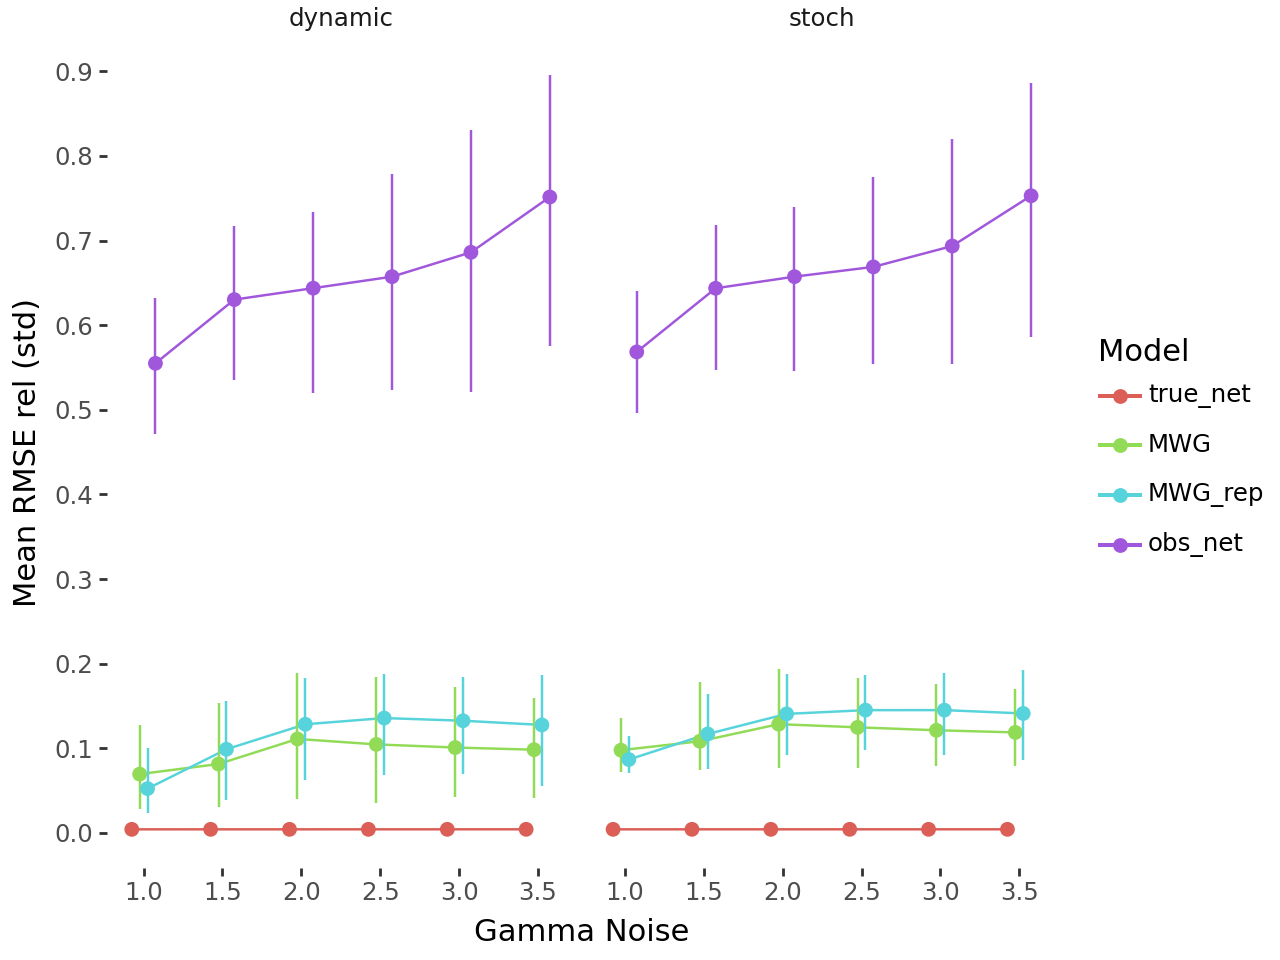

In [23]:
# 'RMSE_rel' mean +- 5%,95% quantiles by method and gamma_noise
# Specify the desired model order


model_order = ["true_net", "MWG", "MWG_rep", "obs_net"]
filtered_df["model"] = pd.Categorical(filtered_df["model"], categories=model_order, ordered=True)

filtered_df["log_rmse"] = np.log(filtered_df["RMSE_rel"])

filtered_df["bias_rel"] = filtered_df["bias"] / filtered_df["true"]
filtered_df["bias_rel_q025"] = (filtered_df["q025"] - filtered_df["true"]) / filtered_df["true"]
filtered_df["bias_rel_q975"] = (filtered_df["q975"] - filtered_df["true"]) / filtered_df["true"]


summary_df = (
    # combined_df
    filtered_df
    .groupby(["gamma_noise", "model", "estimand"])
    .agg(
        mean_RMSE_rel=("RMSE_rel", "mean"),
        median_RMSE_rel=("RMSE_rel", "median"),
        mean_RMSE_rel_std=("RMSE_rel", "std"),
        rmse_rel_q5=("RMSE_rel", lambda x: np.percentile(x, 5)),
        rmse_rel_q95=("RMSE_rel", lambda x: np.percentile(x, 95)),
        mean_MAPE = ("MAPE", "mean"),
        median_MAPE = ("MAPE", "median"),
        mean_MAPE_std = ("MAPE", "std"),
        mape_q5 = ("MAPE", lambda x: np.percentile(x, 5)),
        mape_q95 = ("MAPE", lambda x: np.percentile(x, 95)),
        # mean_rmse = ("RMSE", "mean"),
        mean_rmse = ("RMSE", "mean"),
        mean_rmse_std = ("RMSE", "std"),
        rmse_q5 = ("RMSE", lambda x: np.percentile(x, 5)),
        rmse_q95 = ("RMSE", lambda x: np.percentile(x, 95)),

        mean_log_rmse = ("log_rmse", "mean"),
        mean_log_rmse_std = ("log_rmse", "std"),
        log_rmse_q5 = ("log_rmse", lambda x: np.percentile(x, 5)),
        log_rmse_q95 = ("log_rmse", lambda x: np.percentile(x, 95)),

        mean_mae = ("MAE", "mean"),
        mean_mae_std = ("MAE", "std"),
        mae_q5 = ("MAE", lambda x: np.percentile(x, 5)),
        mae_q95 = ("MAE", lambda x: np.percentile(x, 95)),

        cover = ("covering", "mean"),
        ind_cover = ("mean_ind_cover", "mean"),

        w_dist = ("w_dist", "mean"),

        mean = ("mean", "mean"),
        median = ("median", "median"),
        std = ("std", "mean"),
        true = ("true", "mean"),
        true_std = ("true", "std"),

        mean_975 = ("q975", "mean"),
        mean_025 = ("q025", "mean"),

        bias = ("bias", "mean"),
        bias_std = ("bias", "std"),

        bias_rel = ("bias_rel", "mean"),
        bias_rel_025 = ("bias_rel_q025", "mean"),
        bias_rel_975 = ("bias_rel_q975", "mean"),
        )
    .reset_index()
)

# summary_df["lower_rmse"] = summary_df["mean_RMSE_rel"] - summary_df["mean_RMSE_rel_std"]
summary_df["lower_rmse"] = summary_df["mean_rmse"] - summary_df["mean_rmse_std"]
# summary_df["upper_rmse"] = summary_df["mean_RMSE_rel"] + summary_df["mean_RMSE_rel_std"]
summary_df["upper_rmse"] = summary_df["mean_rmse"] + summary_df["mean_rmse_std"]

summary_df["lower_log_rmse"] = summary_df["mean_log_rmse"] - summary_df["mean_log_rmse_std"]
summary_df["upper_log_rmse"] = summary_df["mean_log_rmse"] + summary_df["mean_log_rmse_std"]

summary_df["lower_mae"] = summary_df["mean_mae"] - summary_df["mean_mae_std"]
summary_df["upper_mae"] = summary_df["mean_mae"] + summary_df["mean_mae_std"]

summary_df["lower_mape"] = summary_df["mean_MAPE"] - summary_df["mean_MAPE_std"]
summary_df["upper_mape"] = summary_df["mean_MAPE"] + summary_df["mean_MAPE_std"]


summary_df = summary_df[summary_df["estimand"] != "estimand"]

(
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                 y="mean_RMSE_rel", 
                                #  y="median_RMSE_rel", 
                                #  y="mean_MAPE", 
                                #  y="median_MAPE", 
                                #  y="mean_rmse", 
                                #  y="mean_mae", 
                                # y= "mean_log_rmse",
                                 group="model", color="model"))
    + p9.geom_line(position=p9.position_dodge(width=0.2))
    
    + p9.geom_pointrange(p9.aes(
                        # ymin="lower_mae", ymax="upper_mae"), 
                        # ymin="lower_rmse", ymax="upper_rmse"), 
                        # ymin="rmse_rel_q5", ymax="rmse_rel_q95"), 
                        ymin="rmse_rel_q5", ymax="rmse_rel_q95"), 
                        # ymin="mape_q5", ymax="mape_q95"),
                        # ymin="lower_log_rmse", ymax="upper_log_rmse"), 
                        # ymin="log_rmse_q5", ymax="log_rmse_q95"), 
                         position=p9.position_dodge(width=0.2),
                           )
    # + p9.geom_pointrange(p9.aes(ymin="mape_q5", ymax="mape_q95"), 
                        #  position=p9.position_dodge(width=0.2),
                        #    )
    # + p9.geom_errorbar(p9.aes(ymin="mape_q5", ymax="mape_q95"), 
    #                      position=p9.position_dodge(width=0.2),
    #                      width=0.2
    #                        )
    # + p9.geom_errorbar(p9.aes(ymin="lower_mape", ymax="upper_mape"), 
                        #  position=p9.position_dodge(width=0.2),
                        #  width=0.2
                        #    )
    # + p9.geom_pointrange(p9.aes(ymin="lower", ymax="upper"), position=p9.position_dodge(width=0.5))
    + p9.theme_tufte()
    + p9.facet_wrap("estimand", scales="fixed")
    # + p9.facet_wrap("estimand", scales="free_y")
    + p9.labs(y="Mean RMSE rel (std)", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_y_continuous(breaks=np.arange(0, 1.0, 0.1))
    + p9.scale_color_discrete(name="Model")
)


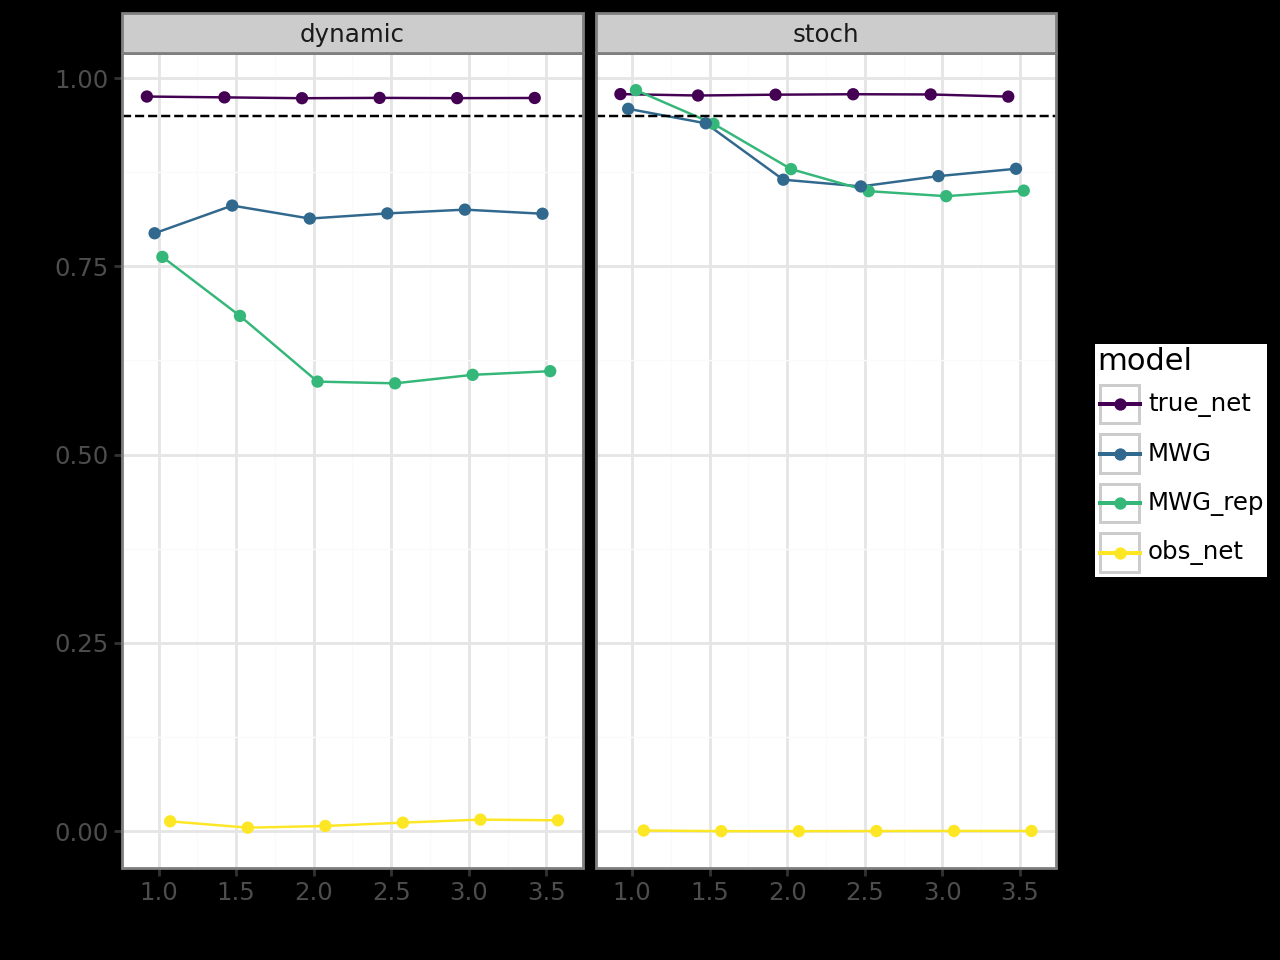

In [18]:


(
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                # y="cover", 
                                y="ind_cover", 
                                group="model",
                                color="model"))
    + p9.geom_line(position=p9.position_dodge(width=0.2))
    + p9.geom_point(position=p9.position_dodge(width=0.2))
    + p9.geom_hline(yintercept=0.95, linetype="dashed")
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")
    # + p9.facet_wrap("estimand", scales="free_y")
    + p9.labs(y="Coverage", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    # + p9.scale_y_continuous(breaks=np.arange(0, 1.0, 0.1))
    # + p9.scale_color_discrete(name="Model")
)


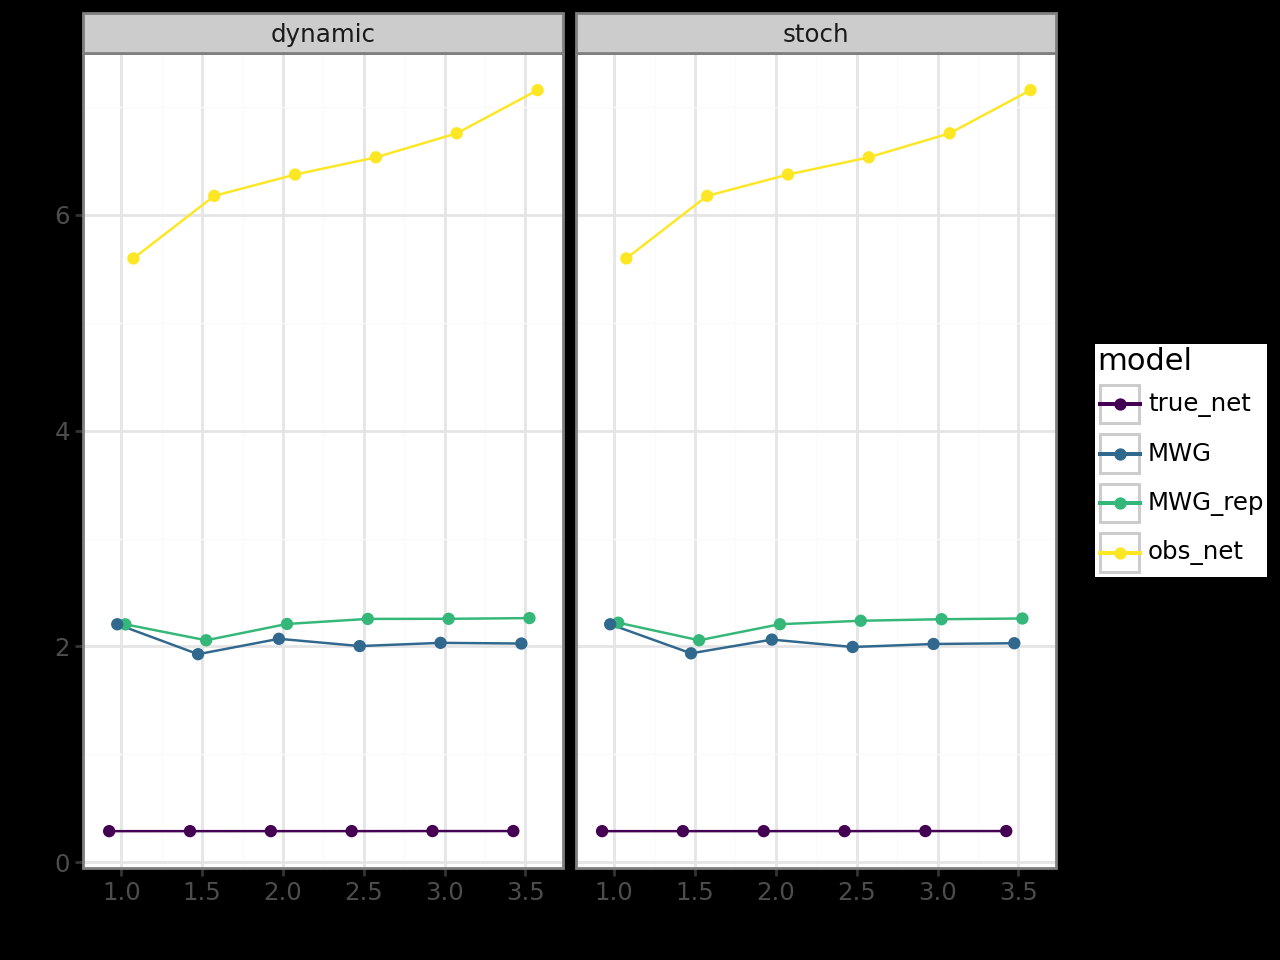

In [19]:
(
    p9.ggplot(summary_df, p9.aes(x="gamma_noise", 
                                # y="cover", 
                                y="w_dist", 
                                group="model",
                                color="model"))
    + p9.geom_line(position=p9.position_dodge(width=0.2))
    + p9.geom_point(position=p9.position_dodge(width=0.2))
    # + p9.geom_hline(yintercept=0.95, linetype="dashed")
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")
    # + p9.facet_wrap("estimand", scales="free_y")
    + p9.labs(y="Coverage", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    # + p9.scale_y_continuous(breaks=n
    # p.arange(0, 1.0, 0.1))
    # + p9.scale_color_discrete(name="Model")
)


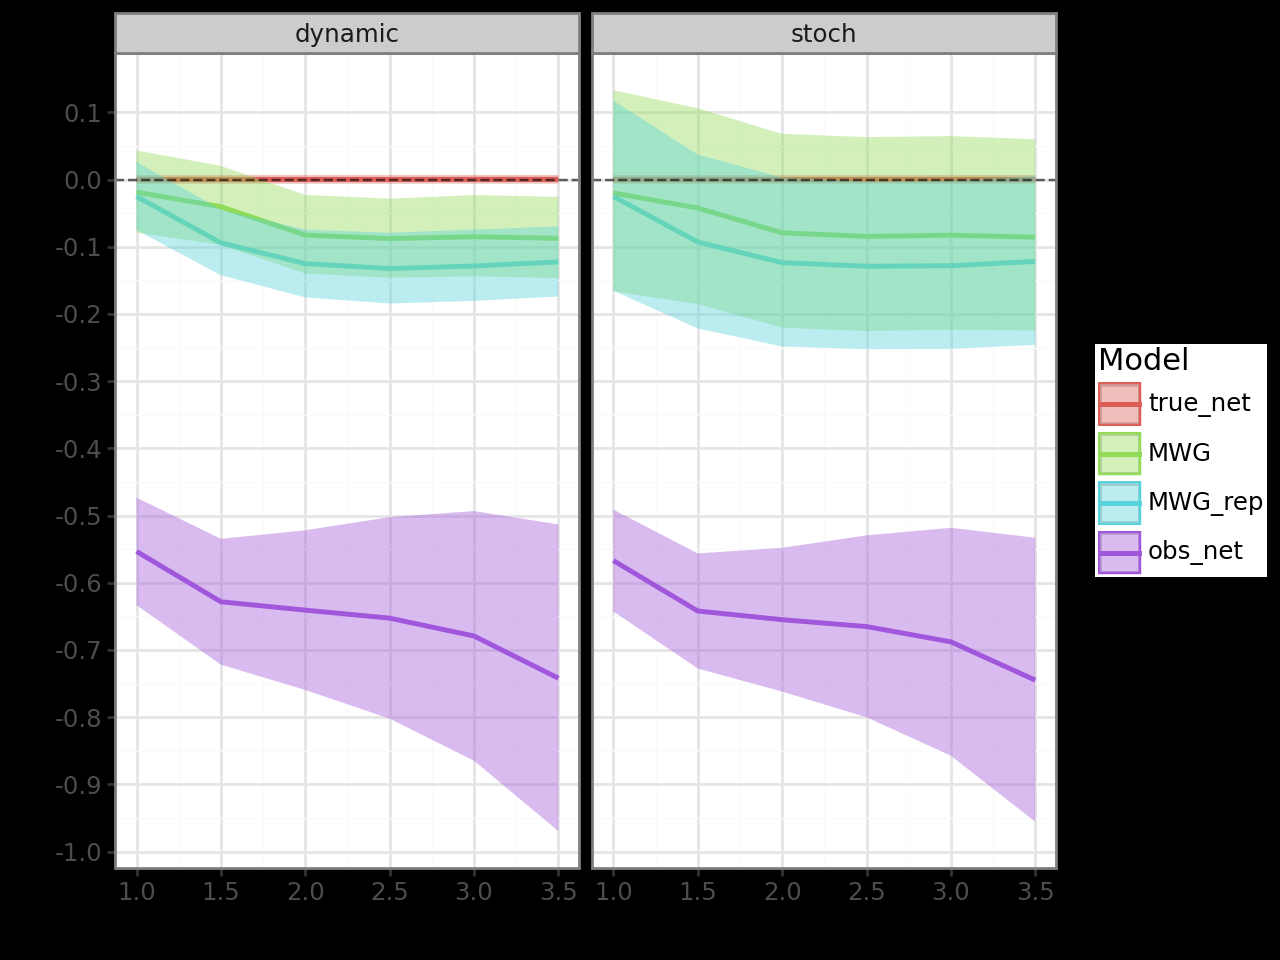

In [24]:

summary_df["mean_m_std"] = summary_df["mean"] - 2*summary_df["std"]
summary_df["mean_p_std"] = summary_df["mean"] + 2*summary_df["std"]

summary_df["true_m_std"] = summary_df["true"] - 2*summary_df["true_std"]
summary_df["true_p_std"] = summary_df["true"] + 2*summary_df["true_std"]

# summary_df["bias_m_std"] = summary_df["bias"] - 2*summary_df["bias_std"]
summary_df["bias_m_std"] = summary_df["bias"] - 2*summary_df["std"]
# summary_df["bias_p_std"] = summary_df["bias"] + 2*summary_df["bias_std"]
summary_df["bias_p_std"] = summary_df["bias"] + 2*summary_df["std"]

summary_df["bias_q975"] = summary_df["mean_975"] - summary_df["true"]
summary_df["bias_q025"] = summary_df["mean_025"] - summary_df["true"]

summary_df["bias_perc"] = summary_df["bias"] / summary_df["true"]

summary_df["bias_perc_q975"] = summary_df["bias_q975"] / summary_df["true"]
summary_df["bias_perc_q025"] = summary_df["bias_q025"] / summary_df["true"]

(
    # p9.ggplot(summary_df[summary_df["model"] != "true_net"], 
    p9.ggplot(summary_df, 
                        p9.aes(x="gamma_noise", 
                                # y="cover", 
                                # y="mean", 
                                # y="bias", 
                                # y="bias_perc", 
                                y="bias_rel", 
                                # y="median", 
                                group="model",
                                color="model",
                                fill = "model"))
    + p9.geom_line(size=1)
    # + p9.geom_ribbon(p9.aes(ymin="mean_025", ymax="mean_975"),
    # + p9.geom_ribbon(p9.aes(ymin="mean_m_std", ymax="mean_p_std"),
    # + p9.geom_ribbon(p9.aes(ymin="bias_m_std", ymax="bias_p_std"),
    # + p9.geom_ribbon(p9.aes(ymin="bias_q025", ymax="bias_q975"),
    # + p9.geom_ribbon(p9.aes(ymin="bias_perc_q025", ymax="bias_perc_q975"),
    + p9.geom_ribbon(p9.aes(ymin="bias_rel_025", ymax="bias_rel_975"),
                        #  position=p9.position_dodge(width=0.2),
                           alpha=0.4,
                         outline_type = "none")
    # + p9.geom_line(p9.aes(y="true"), linetype="dashed", color="black")
    # + p9.geom_pointrange(p9.aes(y="true", ymin="true_m_std", ymax = "true_p_std"),
                        #   linetype="dashed", color="black")
    # + p9.geom_line(p9.aes(y="true"), linetype="dashed", color="black", alpha=0.6)
    + p9.geom_hline(yintercept=0.0, linetype="dashed", color="black", alpha=0.6)
    # + p9.geom_hline(yintercept=0.95, linetype="dashed")
    + p9.theme_bw()
    + p9.facet_wrap("estimand", scales="fixed")
    # + p9.facet_wrap("estimand", scales="free_y")
    + p9.labs(y="Coverage", x="Gamma Noise")
    + p9.scale_x_continuous(breaks=summary_df["gamma_noise"].unique())
    + p9.scale_y_continuous(breaks=np.arange(-1.0, 0.2, 0.1))
    + p9.scale_color_discrete(name="Model")
    + p9.scale_fill_discrete(name="Model")
)

In [22]:
summary_df




,gamma_noise,model,estimand,mean_RMSE_rel,median_RMSE_rel,mean_RMSE_rel_std,rmse_rel_q5,rmse_rel_q95,mean_MAPE,median_MAPE,...,mean_p_std,true_m_std,true_p_std,bias_m_std,bias_p_std,bias_q975,bias_q025,bias_perc,bias_perc_q975,bias_perc_q025
0,1.0,true_net,dynamic,0.004312,0.003960,0.001097,0.003070,0.006553,0.002766,0.002410,...,4.117484,3.405583,4.774271,-0.025938,0.027557,0.027009,-0.025437,0.000198,0.006604,-0.006219
2,1.0,true_net,stoch,0.004317,0.003950,0.001097,0.003085,0.006529,0.002476,0.002130,...,5.188025,4.748944,5.557403,-0.032627,0.034851,0.034155,-0.031996,0.000216,0.006628,-0.006209
3,1.0,MWG,dynamic,0.069576,0.063180,0.034642,0.028404,0.127817,0.176190,0.168800,...,4.217734,3.340344,4.743180,-0.337783,0.175973,0.169374,-0.322998,-0.020017,0.041906,-0.079915
5,1.0,MWG,stoch,0.097850,0.090940,0.022639,0.072041,0.136198,0.084331,0.079780,...,5.813863,4.712806,5.560858,-0.886931,0.677029,0.680177,-0.857091,-0.020431,0.132412,-0.166852
6,1.0,MWG_rep,dynamic,0.052436,0.043620,0.027589,0.023379,0.099850,0.157205,0.155520,...,4.188179,3.357369,4.790058,-0.319332,0.114465,0.106848,-0.306771,-0.025145,0.026229,-0.075305
8,1.0,MWG_rep,stoch,0.086807,0.079755,0.019518,0.071267,0.115123,0.072808,0.065780,...,5.750867,4.743395,5.535678,-0.871347,0.611331,0.603230,-0.851402,-0.025296,0.117370,-0.165657
9,1.0,obs_net,dynamic,0.554926,0.557010,0.054928,0.471148,0.631957,0.590092,0.591035,...,2.158664,3.405583,4.774271,-2.599077,-1.931263,-1.937719,-2.592090,-0.553841,-0.473778,-0.633774
11,1.0,obs_net,stoch,0.568398,0.569740,0.048779,0.496578,0.640827,0.556078,0.557020,...,2.628189,4.748944,5.557403,-3.321801,-2.524985,-2.532727,-3.313422,-0.567299,-0.491489,-0.642987
12,1.5,true_net,dynamic,0.004333,0.003930,0.001121,0.003061,0.006564,0.002783,0.002380,...,4.111927,3.397770,4.771221,-0.026008,0.027431,0.026926,-0.025456,0.000174,0.006592,-0.006232
14,1.5,true_net,stoch,0.004337,0.003950,0.001121,0.003044,0.006507,0.002498,0.002190,...,5.185746,4.742238,5.559775,-0.032724,0.034739,0.034098,-0.032020,0.000196,0.006620,-0.006216
